In [708]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [709]:
n_variate = 1

In [710]:

#Load dataset
def load_dataset(path=r'covid_portugal.csv'):
  return pd.read_csv(path)

In [711]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [712]:
def prepare_data(df):
  # row 60 tem valores errados
  df_aux = df.drop([60])
  df_aux["data"] = pd.to_datetime(df_aux["data"])
  df_aux = df_aux.set_index('data')
  # por obitos como primeira coluna
  df_aux = df_aux.reindex(columns=['obitos', 'confirmados_arsnorte', 'confirmados_arscentro', 'confirmados_arslvt',
       'confirmados_arsalentejo', 'confirmados_arsalgarve',
       'confirmados_acores', 'confirmados_madeira', 'confirmados_novos',
       'recuperados', 'internados', 'internados_uci', 'vigilancia',
       'confirmados_0_9_f', 'confirmados_0_9_m', 'confirmados_10_19_f',
       'confirmados_10_19_m', 'confirmados_20_29_f', 'confirmados_20_29_m',
       'confirmados_30_39_f', 'confirmados_30_39_m', 'confirmados_40_49_f',
       'confirmados_40_49_m', 'confirmados_50_59_f', 'confirmados_50_59_m',
       'confirmados_60_69_f', 'confirmados_60_69_m', 'confirmados_70_79_f',
       'confirmados_70_79_m', 'confirmados_80_plus_f', 'confirmados_80_plus_m',
       'confirmados_f', 'confirmados_m', 'obitos_arsnorte', 'obitos_arscentro',
       'obitos_arslvt', 'obitos_arsalentejo', 'obitos_arsalgarve',
       'obitos_acores', 'obitos_madeira', 'obitos_0_9_f', 'obitos_0_9_m',
       'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
       'obitos_30_39_f', 'obitos_30_39_m', 'obitos_40_49_f', 'obitos_40_49_m',
       'obitos_50_59_f', 'obitos_50_59_m', 'obitos_60_69_f', 'obitos_60_69_m',
       'obitos_70_79_f', 'obitos_70_79_m', 'obitos_80_plus_f',
       'obitos_80_plus_m', 'obitos_f', 'obitos_m', 'ativos',
       'internados_enfermaria', 'Rt_número_de_reprodução', 'Max_Temp',
       'Min_Temp', 'Temperature', 'Precipitation', 'Wind_Speed',
       'Wind_Direction', 'Visibility', 'Cloud_Cover', 'Relative_Humidity',
       'Rain', 'Clear', 'Partially_cloudy', 'flights', 'commercial_flights'])
  # drop de features com correlação alta a outras
  df_aux = df_aux.drop(columns=['Rain','Max_Temp','Min_Temp','internados_enfermaria','confirmados_0_9_m','confirmados_10_19_f', 
                                'confirmados_10_19_m', 'confirmados_20_29_f', 'confirmados_20_29_m', 'confirmados_30_39_f', 
                                'confirmados_30_39_m','confirmados_40_49_f', 'confirmados_40_49_m', 'confirmados_50_59_f', 
                                'confirmados_50_59_m', 'confirmados_60_69_f', 'confirmados_60_69_m', 'confirmados_70_79_f', 
                                'confirmados_70_79_m', 'confirmados_80_plus_f', 'obitos_30_39_f', 'obitos_30_39_m', 'obitos_40_49_f', 
                                'obitos_40_49_m', 'obitos_50_59_f', 'obitos_50_59_m', 'obitos_60_69_f', 'obitos_60_69_m', 'obitos_70_79_f', 
                                'obitos_70_79_m', 'obitos_80_plus_f','obitos_80_plus_m','confirmados_m', 'confirmados_f',
                                'confirmados_arscentro', 'confirmados_arslvt', 'confirmados_arsalentejo', 'confirmados_arsalgarve',
                                'obitos_arsalgarve','obitos_arsalentejo','obitos_arslvt', 'obitos_f', 'obitos_m'])
  # fazer drop das colunas descartadas pelo feature selection
  df_aux = df_aux.drop(columns=['obitos_arscentro', 'obitos_madeira', 'obitos_0_9_f', 'obitos_0_9_m', 'obitos_10_19_f',
                    'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m', 'ativos', 'Rt_número_de_reprodução', 'Temperature', 'Cloud_Cover',
                    'Clear', 'Partially_cloudy', 'commercial_flights'])
  # df_aux = df_aux.drop(columns=[ 'obitos_0_9_f', 'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
  #                               'ativos', 'Partially_cloudy', 'commercial_flights'])
  return df_aux

In [713]:
# def data_normalization(df, norm_range=(-1, 1)):
#   #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
#   scaler = MinMaxScaler(feature_range=norm_range)
#   df = scaler.fit_transform(df)
#   return scaler

In [714]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  colunas = [x for x in df.columns if x != 'obitos']
  for col in colunas:
    df[[col]] = scaler.fit_transform(df[[col]])
  df[['obitos']] = scaler.fit_transform(df[['obitos']])
  return scaler

In [715]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.plot(epochs_range,mae,label='Training MAE')
  plt.plot(epochs_range,val_mae,label='Validation MAE')
  plt.plot(epochs_range,rmse,label='Training RMSE')
  plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [716]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [717]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
      # y.append(data[input_index:label_index, 0:n_variate])

  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [718]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [719]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
    #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  # model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'Covid_model.png', show_shapes=True)
  return model

In [720]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False)
    # history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [721]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)

scaler = data_normalization(df) #scaling data to [-1, 1]

In [722]:
df

,obitos,confirmados_arsnorte,confirmados_acores,confirmados_madeira,confirmados_novos,recuperados,internados,internados_uci,vigilancia,confirmados_0_9_f,confirmados_80_plus_m,obitos_arsnorte,obitos_acores,Precipitation,Wind_Speed,Wind_Direction,Visibility,Relative_Humidity,flights
data,,,,,,,,,,,,,,,,,,,
2020-03-01,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.102995,9.790210e-02,0.033712,-1.000000,-1.000000,-1.000000,-1.0,-0.945502,0.295964,0.342525,0.385214,0.309775,0.974134
2020-03-08,-1.000000,-0.998436,-1.000000,-1.000000,-0.999305,-1.000000,0.124909,9.790210e-02,0.042430,-1.000000,-1.000000,-1.000000,-1.0,-0.942593,0.515695,0.380324,0.657588,0.247153,1.000000
2020-03-15,-1.000000,-0.994242,-0.995960,-1.000000,-0.995023,-0.999950,0.182615,1.608392e-01,0.114555,-1.000000,-0.998392,-1.000000,-1.0,-1.000000,0.035874,0.428688,0.642023,0.005619,0.799439
2020-03-22,-0.986090,-0.948678,-0.987879,-0.985801,-0.968630,-0.999925,0.124909,3.216783e-01,0.189156,-0.987328,-0.966238,-0.976415,-1.0,-0.913890,0.394619,-0.183132,0.268482,-0.039815,0.042997
2020-03-29,-0.895678,-0.806298,-0.882828,-0.926978,-0.899015,-0.999047,0.334551,7.762238e-01,0.135580,-0.982855,-0.838424,-0.735849,-1.0,-1.000000,0.217489,-0.164760,0.322957,-0.065657,-0.651884
2020-04-05,-0.825137,-0.788172,-0.862626,-0.981744,-0.876929,-0.999198,0.539810,1.000000e+00,0.139500,-0.969437,-0.769293,-0.542453,-1.0,-0.427072,0.757848,-0.195723,0.136187,0.474564,-0.887802
2020-04-12,-0.792350,-0.771325,-0.890909,-0.985801,-0.877137,-0.994934,0.170928,-1.748252e-01,0.069443,-0.950801,-0.748392,-0.424528,0.6,-0.405070,-0.168161,0.206129,-0.548638,0.792422,-1.000000
2020-04-19,-0.791356,-0.829329,-0.951515,-0.995943,-0.916170,-0.991649,0.151205,6.993007e-02,0.090390,-0.974655,-0.851286,-0.391509,-0.6,-0.192135,0.789238,0.064124,0.159533,0.537847,-0.925390
2020-04-26,-0.812221,-0.853782,-0.943434,-0.949290,-0.919504,-0.981970,-0.070855,-1.958042e-01,0.082588,-0.989564,-0.848071,-0.481132,0.2,-0.758867,0.172646,0.650032,0.260700,0.299618,-0.840441


In [723]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    # se for necessário prever mais do que 1 semana
    # list_yhat = [yhat[0][i] for i in range(len(yhat[0]))]
    # print('list_yhat:')
    # print(list_yhat)
    # #preparar novo input para fazer previsão para a semana seguinte
    # inp= np.append(inp[0],[list_yhat],axis=0) #adiciona previsão recente ao input
    # inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
    # print('forecasts:')
    # print(forecasts)
  return forecasts



In [724]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(20,8))
  plt.plot(range(len(data)), data['obitos'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Óbitos em Portugal')
  plt.ylabel('Número de Óbitos')
  plt.xlabel('Semanas')
  plt.legend()
  plt.show()

# Tunning

In [725]:
tunning_dict = {               
                1: {'timesteps' : 6, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 2 },
                # 2: {'timesteps' : 4, 'multisteps' : 4, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                # 3: {'timesteps' : 4, 'multisteps' : 4, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 },

                #
                # 4: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 2 },
                # 5: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                # 6: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 }#,
                #
                #7: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits': 5, 'epochs' : 10,  'batch_size' : 1 },
                #8: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 50,  'batch_size' : 1 },
                #9: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 100,  'batch_size' : 1 }

                }
# record da history de cada modelo
record = {}

Epoch 1/25
6/6 [==============================] - 4s 224ms/step - loss: 0.8210 - mae: 0.8164 - rmse: 0.8210 - val_loss: 0.7691 - val_mae: 0.7488 - val_rmse: 0.7691
Epoch 2/25
6/6 [==============================] - 0s 22ms/step - loss: 0.6131 - mae: 0.5816 - rmse: 0.6131 - val_loss: 0.4940 - val_mae: 0.4133 - val_rmse: 0.4940
Epoch 3/25
6/6 [==============================] - 0s 23ms/step - loss: 0.3564 - mae: 0.3034 - rmse: 0.3564 - val_loss: 0.2302 - val_mae: 0.1902 - val_rmse: 0.2302
Epoch 4/25
6/6 [==============================] - 0s 23ms/step - loss: 0.1904 - mae: 0.1563 - rmse: 0.1904 - val_loss: 0.0815 - val_mae: 0.0671 - val_rmse: 0.0815
Epoch 5/25
6/6 [==============================] - 0s 21ms/step - loss: 0.1265 - mae: 0.1094 - rmse: 0.1265 - val_loss: 0.0826 - val_mae: 0.0623 - val_rmse: 0.0826
Epoch 6/25
6/6 [==============================] - 0s 24ms/step - loss: 0.1129 - mae: 0.0979 - rmse: 0.1129 - val_loss: 0.0603 - val_mae: 0.0490 - val_rmse: 0.0603
Epoch 7/25
6/6 [=====

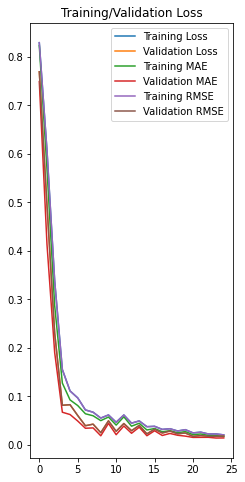

Epoch 1/25
12/12 [==============================] - 1s 98ms/step - loss: 0.0271 - mae: 0.0242 - rmse: 0.0271 - val_loss: 0.0290 - val_mae: 0.0254 - val_rmse: 0.0290
Epoch 2/25
12/12 [==============================] - 0s 13ms/step - loss: 0.0569 - mae: 0.0520 - rmse: 0.0569 - val_loss: 0.0411 - val_mae: 0.0352 - val_rmse: 0.0411
Epoch 3/25
12/12 [==============================] - 0s 13ms/step - loss: 0.0596 - mae: 0.0514 - rmse: 0.0596 - val_loss: 0.0715 - val_mae: 0.0677 - val_rmse: 0.0715
Epoch 4/25
12/12 [==============================] - 0s 14ms/step - loss: 0.0817 - mae: 0.0680 - rmse: 0.0817 - val_loss: 0.0637 - val_mae: 0.0485 - val_rmse: 0.0637
Epoch 5/25
12/12 [==============================] - 0s 14ms/step - loss: 0.0711 - mae: 0.0617 - rmse: 0.0711 - val_loss: 0.0619 - val_mae: 0.0556 - val_rmse: 0.0619
Epoch 6/25
12/12 [==============================] - 0s 14ms/step - loss: 0.0579 - mae: 0.0529 - rmse: 0.0579 - val_loss: 0.0314 - val_mae: 0.0265 - val_rmse: 0.0314
Epoch 7/25

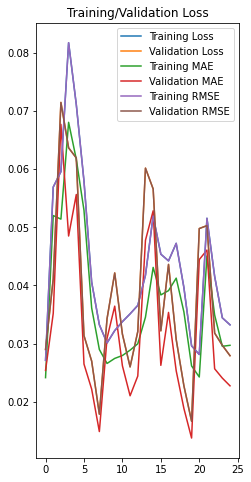

Epoch 1/25
18/18 [==============================] - 0s 17ms/step - loss: 0.0564 - mae: 0.0516 - rmse: 0.0564 - val_loss: 0.2071 - val_mae: 0.2011 - val_rmse: 0.1841
Epoch 2/25
18/18 [==============================] - 0s 12ms/step - loss: 0.0496 - mae: 0.0452 - rmse: 0.0496 - val_loss: 0.1576 - val_mae: 0.1533 - val_rmse: 0.1614
Epoch 3/25
18/18 [==============================] - 0s 12ms/step - loss: 0.0424 - mae: 0.0384 - rmse: 0.0424 - val_loss: 0.1886 - val_mae: 0.1845 - val_rmse: 0.1673
Epoch 4/25
18/18 [==============================] - 0s 12ms/step - loss: 0.0567 - mae: 0.0519 - rmse: 0.0567 - val_loss: 0.1490 - val_mae: 0.1456 - val_rmse: 0.1560
Epoch 5/25
18/18 [==============================] - 0s 12ms/step - loss: 0.0611 - mae: 0.0559 - rmse: 0.0611 - val_loss: 0.1490 - val_mae: 0.1460 - val_rmse: 0.1558
Epoch 6/25
18/18 [==============================] - 0s 13ms/step - loss: 0.0880 - mae: 0.0829 - rmse: 0.0880 - val_loss: 0.1250 - val_mae: 0.1198 - val_rmse: 0.1450
Epoch 7/25

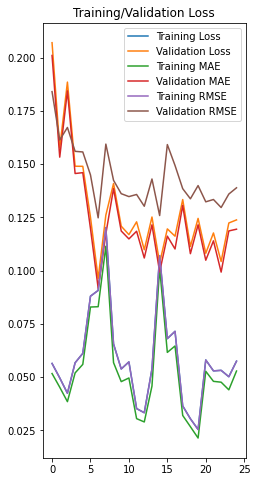

[array([[ 87.08102 , 152.2981  , 192.28053 , 107.72099 , 178.85126 ,
        140.61914 , 167.63063 , 110.63828 , 128.12148 , 148.29514 ,
        163.6393  ,  85.129715, 121.16245 ,  57.37078 ,  31.355938,
        139.22878 , 139.19937 , 102.47978 , 162.59778 ]], dtype=float32)]
Previsões:
[87.08102]


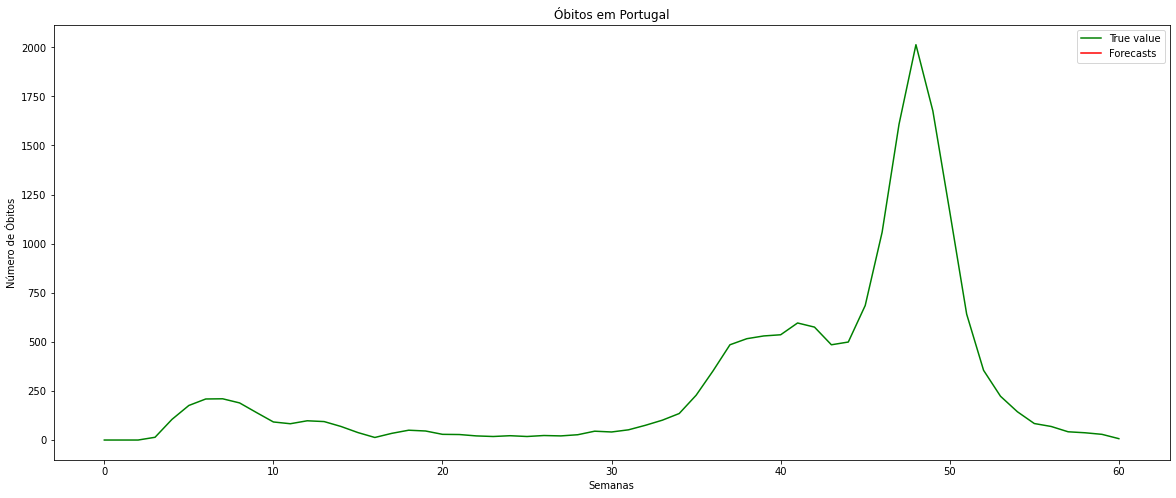

In [726]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print('Previsões:')
  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [727]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [728]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.07290218283732731, 0.06573272866507372, 0.07290218283732731, 0.08586164876818658, 0.07894167214632035, 0.09083205426732699] 



,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.072902,0.065733,0.072902,0.085862,0.078942,0.090832
